In [149]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import astropy.coordinates as apy_coord
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style='ticks', color_codes=True)
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

In [180]:
# Upload the ALFALFA catalog
alf_cat_100 = pd.read_csv('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/ALFALFA/alfalfa.gridsa_160317.csv',
                          index_col=0)
alf_cat_70 = pd.read_csv('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/ALFALFA/a70_151111.csv',
                          index_col=0)

# Create a SkyCoord object with all of the coordinates for the ALFALFA sources
alf_coords_100 = apy_coord.SkyCoord(alf_cat_100['HIra']*u.deg, alf_cat_100['HIdec']*u.deg, frame='icrs')
alf_coords_70 = apy_coord.SkyCoord(alf_cat_70['HIra']*u.deg, alf_cat_70['HIdec']*u.deg, frame='icrs')

In [116]:
# Upload the BAT data
# Upload the fits for the BAT AGN
bat_casey = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected.csv', index_col=0)

# Upload the coordinates of the BAT AGN 
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))
bat_casey_undetected['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                                np.log10(bat_koss['SDSS_Li']/3.846e33))

In [126]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv',
                        index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)

# Upload the HRS info
hrs_coords = np.loadtxt(gh_dir+'hrs-data/hrs_coordinates.txt')
hrs_coords = pd.DataFrame( hrs_coords[:,0:2], index=hrs_coords[:,2], columns=['RA_deg', 'DEC_deg'])

hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

# HRS gas-rich galaxies
hrs_gas_rich = np.array([np.loadtxt(gh_dir+'hrs-data/hrs_gas_rich_numbers.txt')], dtype = int)[0]

hrs_casey['Mstar'] = hrs_info['logMstart']
hrs_casey_undetected['Mstar'] = hrs_info['logMstart']

In [200]:
# Create a DataFrame to hold the results of the search of the catalog
bat_hI = pd.DataFrame(index=bat_info.index, columns=['HIra', 'HIdec', 'sep', 'HIflux', 'HIerr', 'HImass', 'HI_OC_Name'])
hrs_hI = pd.DataFrame(index=hrs_coords.index, columns=['HIra', 'HIdec', 'sep', 'HIflux', 'HIerr', 'HImass', 'HI_OC_Name'])

In [201]:
for n in bat_hI.index:
    
    bat_ra = bat_info.loc[n, 'RA_deg']*u.deg
    bat_dec = bat_info.loc[n, 'DEC_deg']*u.deg
    
    bat_coord = apy_coord.SkyCoord(bat_ra, bat_dec, frame='icrs')
    seps = bat_coord.separation(alf_coords_70)
    
    min_sep = np.min(seps)
    
    if min_sep < 1*u.arcmin:
        src = alf_cat_70.index[np.argmin(seps)]
        bat_hI.loc[n, 'HIra'] = alf_cat_70.loc[src, 'HIra']
        bat_hI.loc[n, 'HIdec'] = alf_cat_70.loc[src, 'HIdec']
        bat_hI.loc[n, 'HIflux'] = alf_cat_70.loc[src, 'flux']
        bat_hI.loc[n, 'HIerr'] = alf_cat_70.loc[src, 'fluxerr']
        bat_hI.loc[n, 'HImass'] = alf_cat_70.loc[src, 'loghimass']
        bat_hI.loc[n, 'HI_OC_Name'] = alf_cat_70.loc[src, 'Name']
        bat_hI.loc[n, 'sep'] = min_sep


In [202]:
for n in hrs_hI.index:
    
    hrs_ra = hrs_coords.loc[n, 'RA_deg']*u.deg
    hrs_dec = hrs_coords.loc[n, 'DEC_deg']*u.deg
    
    hrs_coord = apy_coord.SkyCoord(hrs_ra, hrs_dec, frame='icrs')
    seps = hrs_coord.separation(alf_coords_100)
    
    min_sep = np.min(seps)
    
    if min_sep < 1*u.arcmin:
        src = alf_cat_100.index[np.argmin(seps)]
        hrs_hI.loc[n, 'HIra'] = alf_cat_100.loc[src, 'HIra']
        hrs_hI.loc[n, 'HIdec'] = alf_cat_100.loc[src, 'HIdec']
        hrs_hI.loc[n, 'HIflux'] = alf_cat_100.loc[src, 'flux']
        hrs_hI.loc[n, 'HIerr'] = alf_cat_100.loc[src, 'fluxerr']
        hrs_hI.loc[n, 'HImass'] = alf_cat_100.loc[src, 'loghimass']
        hrs_hI.loc[n, 'HI_OC_Name'] = alf_cat_100.loc[src, 'Name']
        hrs_hI.loc[n, 'sep'] = min_sep

In [184]:
# Get rid of the unmatched BAT AGN
bat_hI = bat_hI.dropna()
hrs_hI = hrs_hI.dropna()
print len(bat_hI), ' BAT sources found with HI data in ALFALFA survey.'
print len(hrs_hI), ' HRS sources found with HI data in ALFALFA survey.'

28  BAT sources found with HI data in ALFALFA survey.
204  HRS sources found with HI data in ALFALFA survey.


In [203]:
bat_hI['mdust'] = bat_casey['mdust']
bat_hI['mstar'] = bat_casey['Mstar']
#bat_hI.loc['Mrk352', 'mdust'] = bat_casey_undetected.loc['Mrk352', 'mdust']
#bat_hI.loc['SDSSJ104326.47+110524.2', 'mdust'] = bat_casey_undetected.loc['Mrk352', 'mdust'] 
#bat_hI.loc['UM614', 'mdust'] = bat_casey_undetected.loc['Mrk352', 'mdust'] 
bat_hI['DTG'] = 10**(bat_hI['mdust'] - bat_hI['HImass'])

In [204]:
hrs_hI = hrs_hI.loc[hrs_gas_rich]
hrs_hI['mdust'] = hrs_casey['mdust']
hrs_hI['mstar'] = hrs_casey['Mstar']
#hrs_hI = hrs_hI.join(hrs_casey_undetected)
hrs_hI['DTG'] = 10**(hrs_hI['mdust'] - hrs_hI['HImass'])

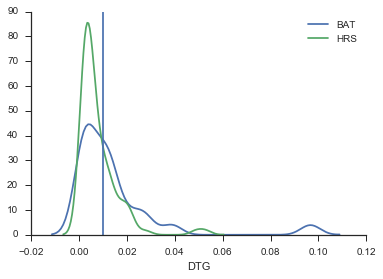

In [205]:
sn.distplot(bat_hI['DTG'].dropna(), hist=False, kde_kws={'clip':(0.0, 0.1)}, label='BAT')
sn.distplot(hrs_hI['DTG'].dropna(), hist=False, kde_kws={'clip':(0.0, 0.1)}, label='HRS')
plt.axvline(1./100.)
sn.despine()

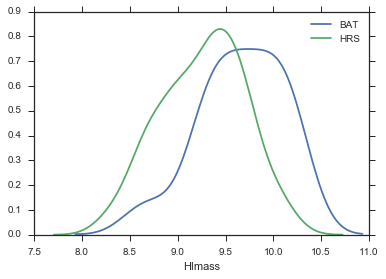

In [206]:
sn.distplot(bat_hI['HImass'].dropna(), hist=False, label='BAT')
sn.distplot(hrs_hI['HImass'].dropna(), hist=False, label='HRS')
plt.legend()

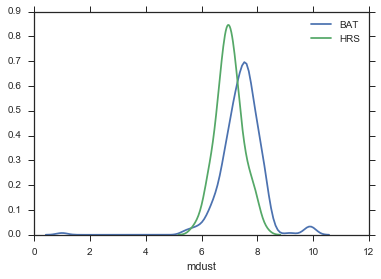

In [207]:
sn.distplot(bat_hI['mdust'].dropna(), hist=False, label='BAT')
sn.distplot(hrs_hI['mdust'].dropna(), hist=False, label='HRS')
plt.legend()

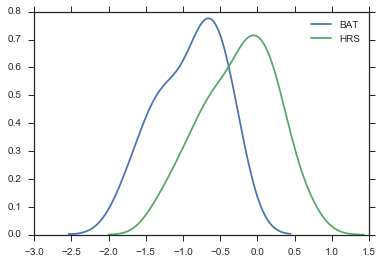

In [208]:
sn.distplot((bat_hI['HImass']-bat_hI['mstar']).dropna(), hist=False, label='BAT')
sn.distplot((hrs_hI['HImass']-hrs_hI['mstar']).dropna(), hist=False, label='HRS')
plt.legend()

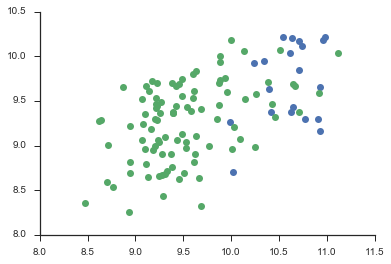

In [209]:
plt.plot(bat_hI['mstar'], bat_hI['HImass'], 'bo')
plt.plot(hrs_hI['mstar'], hrs_hI['HImass'], 'go')
sn.despine()

In [210]:
bat_hI['sfr'] = bat_casey['lir_bb'] + np.log10(4./3.) + np.log10(3.846e33) - np.log10(2.57e43)
hrs_hI['sfr'] = hrs_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)

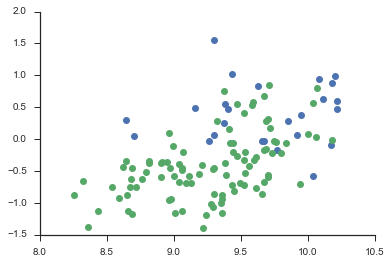

In [211]:
plt.plot(bat_hI['HImass'], bat_hI['sfr'], 'bo')
plt.plot(hrs_hI['HImass'], hrs_hI['sfr'], 'go')
sn.despine()

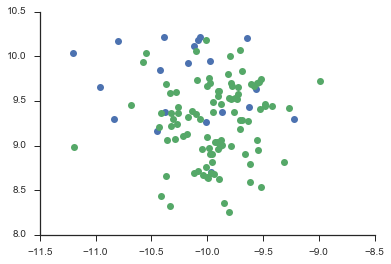

In [212]:
plt.plot(bat_hI['sfr']-bat_hI['mstar'], bat_hI['HImass'], 'bo')
plt.plot(hrs_hI['sfr']-hrs_hI['mstar'], hrs_hI['HImass'], 'go')
sn.despine()

,HIra,HIdec,sep,HIflux,HIerr,HImass,HI_OC_Name
Name,,,,,,,
NGC3227,155.871,19.8628,0d00m22.6354s,17.52,0.1,9.16,N3227
NGC4180,183.262,7.03917,0d00m03.1186s,3.16,0.11,8.64,N4180
NGC4388,186.454,12.6606,0d00m32.7557s,7.57,0.13,8.7,N4388
NGC7465,345.498,15.9669,0d00m23.1371s,24.01,0.11,9.67,N7465
NGC7479,346.234,12.3217,0d00m08.2693s,33.43,0.11,9.98,N7479
